# Deep Kernel Learning

Author: [Zeel B Patel](https://patel-zeel.github.io/)

We will attempt to implement an idea presented in {cite}`AGWDeep`.

In [1]:
import scipy.stats
from scipy.optimize import minimize
import numpy
import matplotlib.pyplot as plt
from matplotlib import rc
from autograd import numpy as np
from autograd import elementwise_grad as egrad
from autograd import grad
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rc('text', usetex=True)
rc('font', size=16)

Defining activation functions.

In [2]:
def relu(z):
    return z.clip(0, np.inf)

def sigmoid(z):
    return 1./(1+np.exp(-z))

def tanh(z):
    return (np.exp(z)-1)/(1+np.exp(z))

Let us visualize these functions.

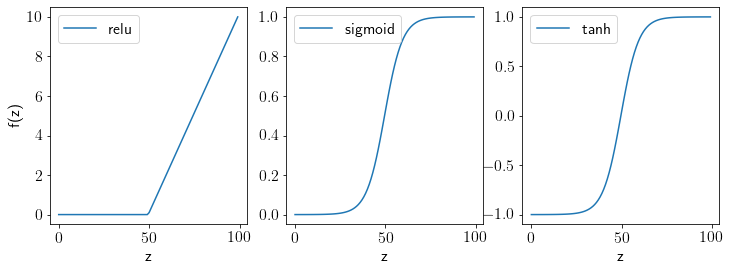

In [3]:
z = np.linspace(-10,10,100)
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(relu(z), label='relu')
ax[1].plot(sigmoid(z), label='sigmoid')
ax[2].plot(tanh(z), label='tanh')
for axx in ax:
    axx.legend();
    axx.set_xlabel('z')
ax[0].set_ylabel('f(z)');

We will consider a step function dataset for this task.

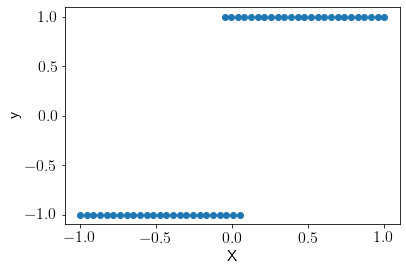

In [4]:
num_low=25
num_high=25
gap = -.1
noise=0.0001
X = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))
scale = np.sqrt(y.var())
offset = y.mean()
y = (y-offset)/scale
plt.scatter(X, y);
plt.xlabel('X')
plt.ylabel('y');

We will initialize the weights and variables to hold intermediate outputs using a function. 

In [5]:
def initialize(seed, sol=[1, 3, 2, 1]):
    np.random.seed(seed)
    size_of_layers = sol

    W = [None]*len(size_of_layers)
    b = [None]*len(size_of_layers)

    # Dummy
    W[0] = np.array([0])
    b[0] = np.array([0])

    for i in range(1, len(size_of_layers)):
        W[i] = np.random.rand(size_of_layers[i], size_of_layers[i-1])
        b[i] = np.random.rand(size_of_layers[i], 1)

    Z = [None]*(len(W))
    Z[0] = np.array([0])

    A = [X]
    A.extend([None]*(len(W)-1))
    sigma, sigma_n, l = np.random.rand(3)
    
    activations = ['relu']*(len(size_of_layers)-2)
    activations.insert(0, 'empty')
    activations.append('tanh')
    
    return W, b, Z, A, sigma, sigma_n, l, activations

activation_func = {'sigmoid':sigmoid, 'relu':relu, 'tanh':tanh}

Let us define the RBF kernel and Negative log likelihood (including a forward pass over neural network).

In [6]:
def RBF(x1, x2, l, sigma):
    d = np.square(x1 - x2.T)
    d_scaled = d/np.square(l)
    
    return sigma**2 * np.exp(-d_scaled)
    
def NegLogLikelihood(W, b, l, sigma, sigma_n):
    for i in range(1, len(W)):
        Z[i] = A[i-1]@(W[i].T) + b[i].T
        A[i] = activation_func[activations[i]](Z[i])
    X_hat = A[-1]

    K = RBF(X_hat, X_hat, l, sigma)
    K += np.eye(X.shape[0])*sigma_n**2
    
    nll = 0.5*y.T@np.linalg.inv(K)@y + 0.5*np.log(np.linalg.det(K)) + 0.5*np.log(2*np.pi)
    return nll[0,0]

Now, we optimize the kernel paramaters as well as weights of neural networks using `autograd`.

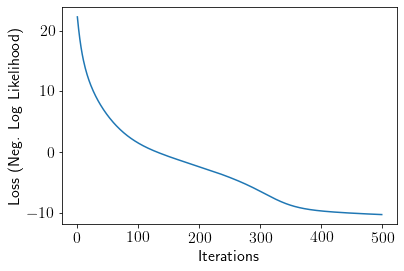

In [7]:
grad_func = grad(NegLogLikelihood, argnum=[0,1,2,3,4])

W, b, Z, A, sigma, sigma_n, l, activations = initialize(seed=0)

lr = 0.0001
loss = []
for iters in range(500):
    dW, db, dl, dsigma, dsigma_n = grad_func(W, b, l, sigma, sigma_n)
    
    for i in range(len(W)):
        W[i] = W[i] - lr*dW[i]
    for i in range(len(b)):
        b[i] = b[i] - lr*db[i]
    l = l - lr*dl
    sigma = sigma - lr*dsigma
    sigma_n = sigma_n - lr*dsigma_n
    
    loss.append(NegLogLikelihood(W, b, l, sigma, sigma_n))

plt.plot(loss);
plt.xlabel('Iterations')
plt.ylabel('Loss (Neg. Log Likelihood)');

Let us define a function to predict the output over new inputs.

In [8]:
def predict(X_new):
    # Getting X_hat
    A[0] = X
    for i in range(1, len(W)):
        Z[i] = A[i-1]@(W[i].T) + b[i].T
        A[i] = activation_func[activations[i]](Z[i])
    X_hat = A[-1]
    
    # Getting X_new_hat
    A[0] = X_new
    for i in range(1, len(W)):
        Z[i] = A[i-1]@(W[i].T) + b[i].T
        A[i] = activation_func[activations[i]](Z[i])
    X_new_hat = A[-1]
    
    K = RBF(X_hat, X_hat, l, sigma)
    K += np.eye(X_hat.shape[0])*sigma_n**2
    K_inv = np.linalg.inv(K)
    
    K_star = RBF(X_hat, X_new_hat, l, sigma)
    K_star_star = RBF(X_new_hat, X_new_hat, l, sigma)
    K_star_star += np.eye(X_new_hat.shape[0])*sigma_n**2 # include likelihood noise
    
    mu = K_star.T@K_inv@y
    cov = K_star_star - K_star.T@K_inv@K_star
    
    return mu.squeeze(), cov

Now, we visualize predicted mean and variance at new inputs.

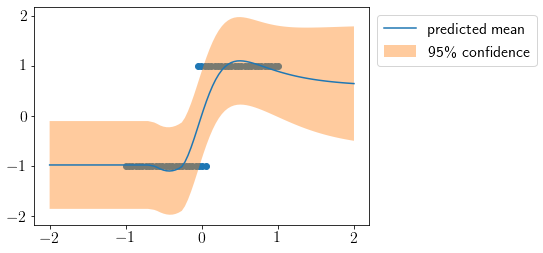

In [9]:
X_new = np.linspace(-2, 2, 100).reshape(-1,1)

mu, cov = predict(X_new)
std2 = np.sqrt(cov.diagonal())*2

plt.scatter(X, y)
plt.plot(X_new, mu, label='predicted mean');
plt.fill_between(X_new.squeeze(), mu-std2, mu+std2, alpha=0.4, label='95\% confidence');
plt.legend(bbox_to_anchor=(1,1));

Let us try one more dataset.

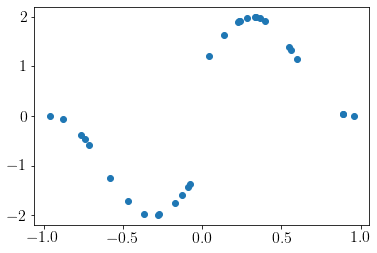

In [10]:
# Generate data
def f(X):  # target function
    return numpy.sin(5*X) + numpy.sign(X)

X = numpy.sort(numpy.random.uniform(-1, 1, (30, 1)))  # data
y = f(X)[:, 0].reshape(-1,1)
plt.scatter(X, y);

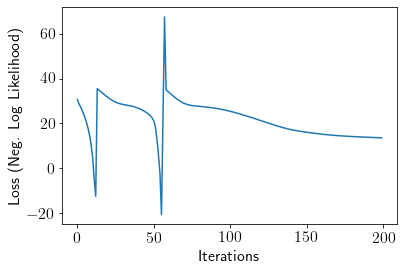

In [11]:
grad_func = grad(NegLogLikelihood, argnum=[0,1,2,3,4])

W, b, Z, A, sigma, sigma_n, l, activations = initialize(seed=0, sol=[1,3,1])

lr = 0.01
loss = []
for iters in range(200):
    dW, db, dl, dsigma, dsigma_n = grad_func(W, b, l, sigma, sigma_n)
    
    for i in range(len(W)):
        W[i] = W[i] - lr*dW[i]
    for i in range(len(b)):
        b[i] = b[i] - lr*db[i]
    l = l - lr*dl
    sigma = sigma - lr*dsigma
    sigma_n = sigma_n - lr*dsigma_n
    
    loss.append(NegLogLikelihood(W, b, l, sigma, sigma_n))

plt.plot(loss);
plt.xlabel('Iterations')
plt.ylabel('Loss (Neg. Log Likelihood)');

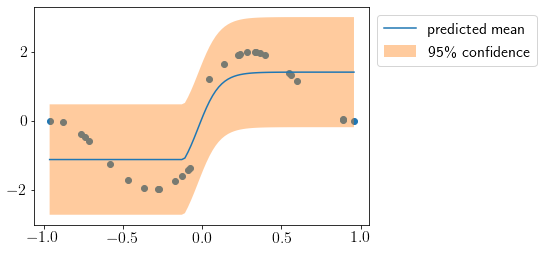

In [12]:
X_new = np.linspace(X.min(), X.max(), 100).reshape(-1,1)

mu, cov = predict(X_new)
std2 = np.sqrt(cov.diagonal())*2

plt.scatter(X, y)
plt.plot(X_new, mu, label='predicted mean');
plt.fill_between(X_new.squeeze(), mu-std2, mu+std2, alpha=0.4, label='95\% confidence');
plt.legend(bbox_to_anchor=(1,1));